In [60]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
import numpy as np
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram as plt_hist
from scipy.optimize import minimize
from matplotlib import pyplot as plt

# **GENERAL ANSATZ** 
## **Objectives:** 
1. Generate an advanced multi-control U gate
2. Generate the non-parametrized general ansatz

In [1]:
#multi-controlled u3
#Parameters: param (list); num_control_qubits (int)
#Return: The multi-controlled u3 Gate object
def mtcu(param, num_control_qubits):
    
    Qbit = QuantumRegister(1)
    qc = QuantumCircuit(Qbit)
    qc.u3(param[0], param[1], param[2], Qbit[0])
    
    gate_label = 'U3({para1:.2f}, {para2:.2f}, {para3:.2f})'.format(para1 = param[0], para2 = param[1], 
                                                                       para3 = param[2])
    u3 = qc.to_gate(label = gate_label)
    
    #control part
    cu3 = u3.control(num_control_qubits)
    
    return cu3

In [19]:
#Append multi-controlled u3 advance to the circuit depends on the bit-string label of the gate
#Parameters: 
    #param(2D list, size (num_qubits * 3))
    #num_ctrlqubits (int)
    #circuit (Circuit Object)
    #ctrlqubits (list)
    #targetqubit (list)
    #bit_str (string)

def mtcu_advance(param, num_ctrlqubits, circuit, ctrlqubits, targetqubits, bit_str):
    cu3 = mtcu(param, num_ctrlqubits)
    
    for i in range(len(bit_str)):
        if bit_str[i] == '0':
            circuit.x(ctrlqubits[i])
    
    circuit.append(cu3, ctrlqubits + targetqubits)
    
    for i in range(len(bit_str)):
        if bit_str[i] == '0':
            circuit.x(ctrlqubits[i])

In [20]:
#generate list of bit_string that can be formed by n qubits (the ordered is not sorted by least to greatest)
#parameters: n (int)
#return: the list of bit strings
def bit_str_list(n):
    bit_str_lst = []
    
    for i in range( 2**n ):
        bit_str = ''
        rev_bit_str = ''
        temp = i
        
        for j in range(n):
            rev_bit_str += str(temp % 2)
            temp = temp // 2
            
        for char in rev_bit_str:
            bit_str = char + bit_str
        
        bit_str_lst.append(rev_bit_str)
    return bit_str_lst

#convert bit_str form to decimal form
#parameters: bit_str (string)
#return: the decimal form of bit_str (int)
def bit_str_to_dec(bit_str):
    dec = 0
    for i in range(len(bit_str)-1, -1,-1):
        bit = int(bit_str[i])
        dec += bit * ( 2 ** (len(bit_str) - 1 - i) )
    return dec

In [10]:
bit_str_list(2)

['00', '10', '01', '11']

In [11]:
bit_str_to_dec('001011')

11

In [15]:
#generate general non-parametrized ansatz for the circuit
#parameters:
    #param (2D list, size num_qubits * 3)
    #qbits (QuantumRegister object)
    #cbits (ClassicalRegister object)
#return: the ansatz (Circuit object)
def general_ansatz(param, qbits, cbits):
    num_qubits = len(qbits)
    qc = QuantumCircuit(qbits, cbits)
    
    #append U3_0 (without control) on the first qubit 
    qc.u3(param[0][0], param[0][1], param[0][2], qbits[len(qbits) - 1 ])
    
    #setup Controlled-U3 
    for i in range(1, num_qubits):
        num_ctrlqubits = i
        #list of ctrlqubits' indexes
        ctrlqubits = [i for i in range(num_qubits - num_ctrlqubits, num_qubits)]
        #list of targetqubits' indexes
        targetqubits = [num_qubits -1 -num_ctrlqubits]
        #generate bit_string list from the number of controlqubits
        bit_str_lst = bit_str_list(num_ctrlqubits)
        #generate sorted bit_string list from the number of controlqubits
        bit_str_lst_sorted = sorted(bit_str_lst)
        
        for j in range(len(bit_str_lst)):
            
            bit_str = bit_str_lst[j]
            gate_idx = bit_str_to_dec('1'+ bit_str_lst_sorted[j]) - 1
            mtcu_advance(param[gate_idx], num_ctrlqubits, qc, ctrlqubits, targetqubits, bit_str)
            
    return qc

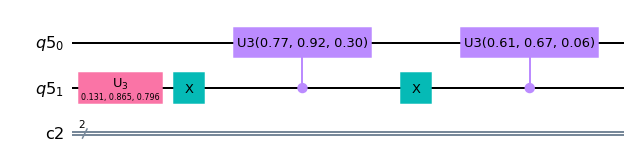

In [22]:
num_qubits = 2

qbits = QuantumRegister(num_qubits)
cbits = ClassicalRegister(num_qubits)

np.random.seed = (99999999)
param = np.random.rand(3 * ( 2 ** num_qubits - 1))

param_i = list(np.random.rand(3))
param = []
for i in range(2 ** num_qubits - 1):
    param.append(list(np.random.rand(3)))


qc = general_ansatz(param, qbits, cbits )
qc.draw('mpl')

# **Measurement for Ising Model**
## **Objectives**
1. Generate measurement circuits to measure the expectation value of the Hamiltonian
2. Use the newly formed circuits to test general ansatz
3. Compute the expectation of Ising Model's Hamiltonian, in terms of the param

In [24]:
#generate measurement circuits to measure term E_Z
#parameters: 
    #theta_list (list of real theta parameters- 1st parameter of each multicontrolled U3)
    # num_qubits (int)
#return: the circuit object represents the measurement circuit
def zz_measurecircuit(theta_list, num_qubits):
    
    #generate param matrix from theta_list
    param = [3 * [0] for _ in range(( 2 ** num_qubits - 1))]
    for i in range(len(param)):
        param[i][0] = theta_list[i]
       
    #generate measure circuit
    qbits = QuantumRegister(num_qubits)
    cbits = ClassicalRegister(num_qubits)
    
    qc = general_ansatz(param, qbits, cbits)
    qc.measure(qbits[:], cbits[:])
    
    return qc

#generate measurement circuits to measure term E_X
#parameters: 
    #theta_list (list of real theta parameters- 1st parameter of each multicontrolled U3)
    # num_qubits (int)
#return: the circuit object represents the measurement circuit
def x_measurecircuit(theta_list, num_qubits):
    #generate param matrix from theta_list
    param = [3 * [0] for _ in range(( 2 ** num_qubits - 1))]
    for i in range(len(param)):
        param[i][0] = theta_list[i]
       
    #generate measure circuit
    qbits = QuantumRegister(num_qubits)
    cbits = ClassicalRegister(num_qubits)
    
    
    qc = general_ansatz(param, qbits, cbits)
    qc.h(qbits[:])
    qc.measure(qbits[:], cbits[:])
    
    return qc

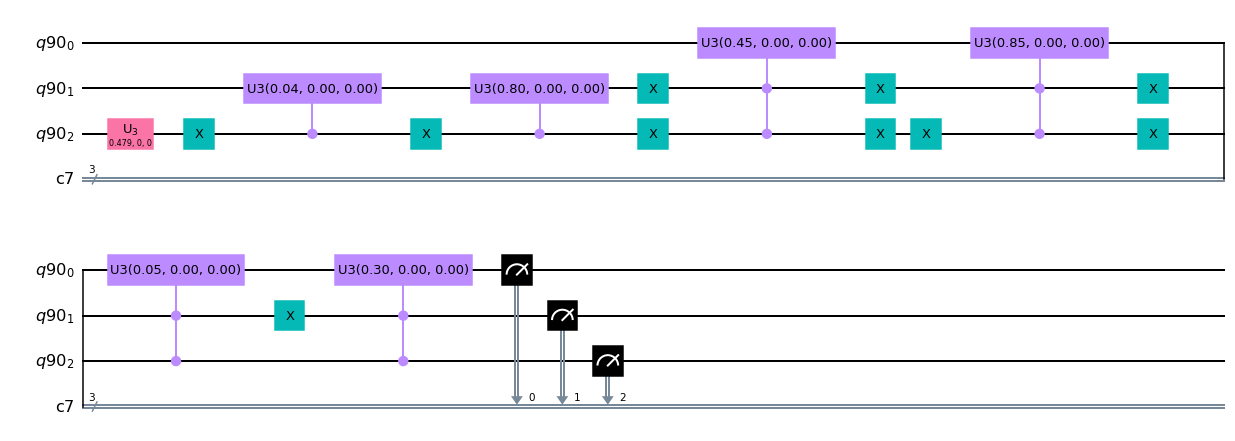

In [29]:
num_qubits = 3
theta_list = np.random.rand(2** num_qubits - 1)

zz_measurecircuit(theta_list, num_qubits).draw('mpl')

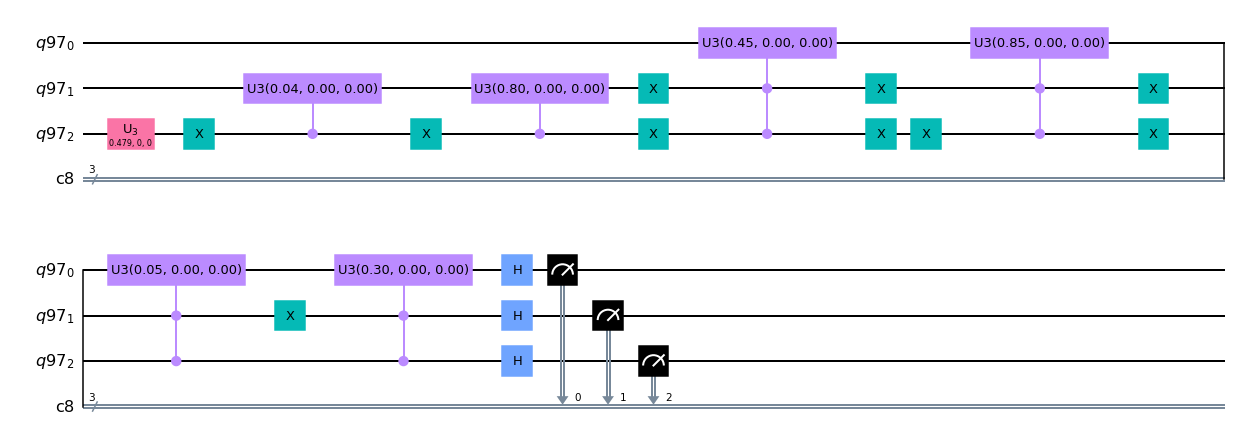

In [30]:
x_measurecircuit(theta_list, num_qubits).draw('mpl')

In [43]:
num_qubits = 3
theta_list = np.random.rand(2**num_qubits - 1)
#theta_list = [i for i in range(1, 2**num_qubits )]

print(theta_list)
#get backend
backend = Aer.get_backend('qasm_simulator')
numshots = 10000

#measure term ZZ
zz_qc = zz_measurecircuit(theta_list, num_qubits)
zz_qc_transpile = transpile(zz_qc, backend = backend)
zz_job = assemble(zz_qc_transpile, backend = backend, shots = numshots)
zz_result = backend.run(zz_job).result()
zz_counts = zz_result.get_counts()
print(zz_counts)

#measure term X
x_qc = x_measurecircuit(theta_list, num_qubits)
x_qc_transpile = transpile(x_qc, backend = backend)
x_job = assemble(x_qc_transpile, backend = backend, shots = numshots)
x_result = backend.run(x_job).result()
x_counts = x_result.get_counts()
print(x_counts)

[0.23655451 0.18020527 0.04948113 0.61220526 0.20882516 0.42423243
 0.38987223]
{'011': 1, '001': 876, '100': 123, '101': 9, '010': 75, '000': 8916}
{'101': 500, '111': 272, '011': 565, '100': 1745, '001': 833, '110': 1272, '000': 2780, '010': 2033}


In [44]:
#circuit test, using zz_measurecircuit
def bit_str_to_dec(bit_str):
    dec = 0
    for i in range(len(bit_str)-1, -1,-1):
        bit = int(bit_str[i])
        dec += bit * ( 2 ** (len(bit_str) - 1 - i) )
        
    return dec

def final_coefficient(bit_str, theta_list):
    coeff = 1
    for i in range(len(bit_str)-1, -1, -1):
        code = '1' + bit_str[:i]
        num = bit_str_to_dec(code) - 1
        #print(num)
        if bit_str[i] == '0':
            coeff *= np.cos(theta_list[num]/2)
        else:
            coeff *= np.sin(theta_list[num]/2)
    return coeff

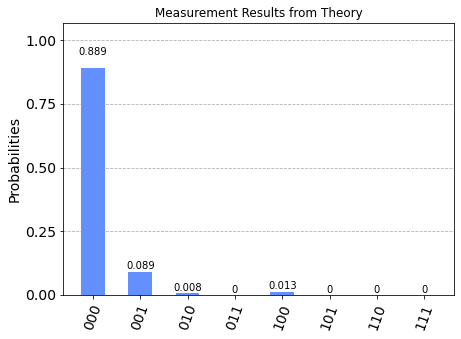

In [47]:
lst = bit_str_list(num_qubits)
lst.sort()

prob_list = []
count = dict()
for element in lst:
    count[element] = final_coefficient(element, theta_list)**2
plt_hist(count, title = 'Measurement Results from Theory')

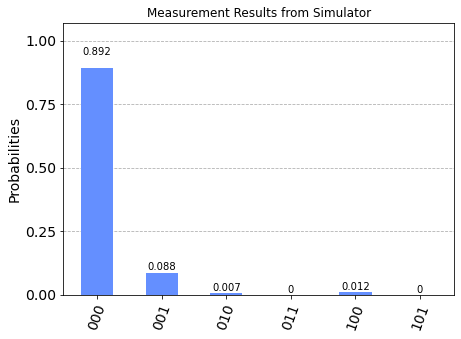

In [48]:
plt_hist(zz_counts, title = 'Measurement Results from Simulator')

In [50]:
#compute the expectation value of term E_zz from the result
#parameter:
    #num_qubits (int)
    #h (float)
    #zz_counts (dictionary)
def zz_measure(num_qubits, zz_counts): 
    zz_exp = 0
    for i in range(num_qubits):
        zz_exp_i = 0
        if i == num_qubits -1:
            for key in zz_counts:
                if key[0] == key[-1]:
                    sign = +1
                else:
                    sign = -1
                zz_exp_i += sign * (zz_counts[key] / numshots)
            
        else:
            for key in zz_counts:
                if key[i] == key[i+1]:
                    sign = +1
                else:
                    sign = -1
                zz_exp_i += sign * (zz_counts[key] / numshots)
        zz_exp += zz_exp_i
        
    return - zz_exp

#print((zz_measure(num_qubits ,zz_counts))) 

In [51]:
#compute the expectation value of term E_x from the result
#parameter:
    #num_qubits (int)
    #h (float)
    #x_counts (dictionary)
def x_measure(num_qubits, h, x_counts):
    x_exp = 0
    for i in range(num_qubits):
        x_exp_i = 0
        for key in x_counts:
        
            if key[i] == '0':
                sign = +1
            else:
                sign = -1
            
            x_exp_i += sign * x_counts[key]/ numshots
            
        x_exp += x_exp_i
    
    return - h * x_exp

#print(x_measure(num_qubits, 1, x_counts))

In [52]:
#compute the expectation value of Ising model's Hamiltonian from the result
#parameter:
    #num_qubits (int)
    #h (float)
    #zz_counts (dictionary)
    #x_counts (dictionary)
def hamiltonian_measure(num_qubits, h, zz_counts, x_counts):
    return zz_measure(num_qubits, zz_counts) + x_measure(num_qubits, h, x_counts)

In [53]:
hamiltonian_measure(num_qubits, 2, zz_counts, x_counts)

-4.526

# **Optimization**
## **Objectives**
1. Define objective function for the optimzation
2. Finding the minimum value (or the system ground state) using Python's scipy.optimize.minimize

In [55]:
#objective_function/ Cost function of this Problem, which is the expectation value of Ising Model's hamiltonian
#parameters:
    #theta_list (list of real theta parameters- 1st parameter of each multicontrolled U3)
    #num_qubits (int)
    #h (float)
#return: the value of the function (float)
def objective_function(theta_list, num_qubits, h ):

    #get backend
    backend = Aer.get_backend('qasm_simulator')
    numshots = 10000

    #measure term ZZ
    zz_qc = zz_measurecircuit(theta_list, num_qubits)
    zz_qc_transpile = transpile(zz_qc, backend = backend)
    zz_job = assemble(zz_qc_transpile, backend = backend, shots = numshots)
    zz_result = backend.run(zz_job).result()
    zz_counts = zz_result.get_counts()
    
    #measure term X
    x_qc = x_measurecircuit(theta_list, num_qubits)
    x_qc_transpile = transpile(x_qc, backend = backend)
    x_job = assemble(x_qc_transpile, backend = backend, shots = numshots)
    x_result = backend.run(x_job).result()
    x_counts = x_result.get_counts()
    
    #measure expectation value of hamiltonian
    h_exp = hamiltonian_measure(num_qubits, h, zz_counts, x_counts)
    
    return h_exp


In [56]:
objective_function([0] * 7, 3, 2)

-2.9876

In [59]:
%%time
num_qubits = 2
sol1 = minimize(fun = objective_function, args = (num_qubits,2) ,x0 = (2**num_qubits - 1) * [0]  ,method = 'COBYLA')
print(sol1)

     fun: -4.3968
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([1.55836453, 0.90967186, 1.78640875])
CPU times: user 2.16 s, sys: 23 ms, total: 2.18 s
Wall time: 2.19 s


In [56]:
Exact_E_range=[-1.0,
 -1.0029172392991268,
 -1.012257949926227,
 -1.0288632926758146,
 -1.0534284786616952,
 -1.0863886888826075,
 -1.1278356834067804,
 -1.177499021376562,
 -1.2348002109808474,
 -1.2989564623667418,
 -1.369095484068181,
 -1.4443501164832224,
 -1.5239197262968904,
 -1.6071003647530555,
 -1.6932925195185922,
 -1.7819957493399936,
 -1.872797183492377,
 -1.9653582149735949,
 -2.059401681437348,
 -2.1547005383792515]

In [243]:
A = [-1.0, -1.002161403508772, -1.0011859649122807, -1.0089964912280702, -1.0415789473684212, -1.0656070175438597, -1.0891859649122806, -1.121578947368421, -1.1538315789473683, -1.1927298245614033, -1.2233473684210525, -1.3054456140350876, -1.4325684210526317, -1.501978947368421, -1.6520070175438597, -1.7649754385964913, -1.7216701754385964, -1.8950877192982458, -2.036870175438596, -2.1306666666666665]

In [244]:
B = [-1.0, -1.001817543859649, -1.0059719298245613, -1.0216491228070175, -1.034617543859649, -1.0619228070175437, -1.0978245614035087, -1.1151298245614034, -1.1488210526315787, -1.2099719298245613, -1.2788210526315789, -1.3227438596491228, -1.4303719298245614, -1.4467859649122807, -1.6676701754385963, -1.712, -1.8175999999999999, -1.79940350877193, -2.013466666666666, -2.0557333333333334]

In [249]:
C = [-1.0, -1.0039368421052632, -1.0070385964912283, -1.0189684210526317, -1.0392210526315788, -1.0716912280701754, -1.0961122807017543, -1.1092701754385965, -1.149957894736842, -1.1882245614035087, -1.231340350877193, -1.3120771929824564, -1.3644280701754388, -1.5098105263157893, -1.6313894736842105, -1.7283508771929827, -1.829157894736842, -1.8780912280701754, -1.8928070175438594, -2.0951999999999997]

In [ ]:
minimize(fun = objective_function, args = (3,0) ,x0 = 7*[0] ,method = 'COBYLA').fun

In [35]:
plt.plot?

In [31]:
plt.plot(h_range, Exact_E_range, 'o', label = 'Exact')
plt.plot(h_range, A , 'o', label = 'VQE')

plt.legend()



plt.show()

NameError: name 'plt' is not defined

In [21]:
%%time
num_qubits = 4
vqe_E_range = []
h_range = np.linspace(0, 2, 20)
x0 = [0] * (2**num_qubits - 1)
for h in h_range:
    sol = minimize(fun = objective_function, args = (num_qubits,h) ,x0 = x0 ,method = 'COBYLA')
    E_value = sol.fun
    vqe_E_range.append(E_value)
    x0 = sol.x

vqe_E_range = list(map(lambda x: x/num_qubits, vqe_E_range))
print(vqe_E_range)




[-1.0, -1.0000473684210527, -1.0071894736842106, -1.0175736842105263, -1.027, -1.0362578947368422, -1.0579947368421052, -1.1005052631578947, -1.1471, -1.1591263157894736, -1.2177894736842105, -1.2554578947368422, -1.3198894736842106, -1.4565473684210524, -1.5427, -1.662863157894737, -1.7827157894736843, -1.839594736842105, -1.9262473684210526, -2.0725000000000002]
CPU times: user 27min 38s, sys: 8.99 s, total: 27min 47s
Wall time: 27min 49s


In [55]:
E = [-1.0,
 -1.0007228070175438,
 -1.006778947368421,
 -1.0182245614035088,
 -1.0296982456140351,
 -1.0275438596491229,
 -1.0737684210526315,
 -1.1016,
 -1.1184280701754385,
 -1.151459649122807,
 -1.1753122807017544,
 -1.2103298245614036,
 -1.2595157894736841,
 -1.4257263157894735,
 -1.638680701743858,
 -1.7553894736842104,
 -1.8737684210526313,
 -1.9405824561403506,
 -2.032659649122807,
 -2.1436]

[-1.0,
 -1.0007228070175438,
 -1.006778947368421,
 -1.0182245614035088,
 -1.0296982456140351,
 -1.0275438596491229,
 -1.0737684210526315,
 -1.1016,
 -1.1184280701754385,
 -1.151459649122807,
 -1.1753122807017544,
 -1.2103298245614036,
 -1.2595157894736841,
 -1.4257263157894735,
 -1.638680701743858,
 -1.7553894736842104,
 -1.8737684210526313,
 -1.9405824561403506,
 -2.032659649122807,
 -2.1436]

In [254]:
Exact_E_range_2=[-1.0,
 -1.005524903923305,
 -1.0219204125761896,
 -1.0486767813248041,
 -1.085027796215174,
 -1.1300479238728363,
 -1.182747634433907,
 -1.2421498653901,
 -1.3073412998288654,
 -1.3775002450844631,
 -1.4519067604351281,
 -1.5299412477630139,
 -1.611076617369892,
 -1.6948675987478545,
 -1.7809394016514346,
 -1.8689769373226002,
 -1.9587151648345673,
 -2.049930746752678,
 -2.142434993373434,
 -2.236067977499789]

In [255]:
D = [-1.0, -1.002578947368421, -1.0106947368421053, -1.0150526315789474, -1.0392736842105263, -1.0644105263157895, -1.095063157894737, -1.1997473684210527, -1.2097157894736843, -1.2481052631578946, -1.295578947368421, -1.5076421052631581, -1.5730631578947367, -1.6581473684210524, -1.771336842105263, -1.8729263157894738, -1.946936842105263, -2.0316947368421054, -2.1512842105263155, -2.1996]

In [257]:
D

[-1.0,
 -1.002578947368421,
 -1.0106947368421053,
 -1.0150526315789474,
 -1.0392736842105263,
 -1.0644105263157895,
 -1.095063157894737,
 -1.1997473684210527,
 -1.2097157894736843,
 -1.2481052631578946,
 -1.295578947368421,
 -1.5076421052631581,
 -1.5730631578947367,
 -1.6581473684210524,
 -1.771336842105263,
 -1.8729263157894738,
 -1.946936842105263,
 -2.0316947368421054,
 -2.1512842105263155,
 -2.1996]

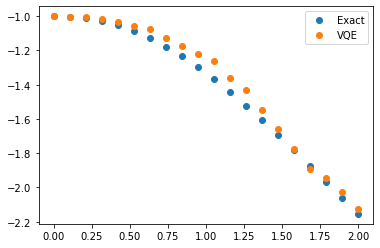

In [60]:
K = [-1.0, -1.0028280701754386, -1.0057894736842106, -1.0181052631578946, -1.0352350877192982, -1.0570105263157894, -1.0773192982456141, -1.1249263157894736, -1.1748280701754388, -1.2219438596491228, -1.262842105263158, -1.3588771929824564, -1.430757894736842, -1.547971929824561, -1.6564491228070175, -1.7769192982456143, -1.8917754385964909, -1.9421824561403505, -2.025010526315789, -2.127466666666667]

plt.plot(h_range, Exact_E_range, 'o', label = 'Exact')
plt.plot(h_range, K, 'o', label = 'VQE')

plt.legend()



plt.show()

In [22]:
Exact_E_range_4 = [-1.0,
 (-1.0027815608119914+0j),
 (-1.0112623393301228+0j),
 (-1.0258369822355347+0j),
 (-1.0471100187152589+0j),
 (-1.0757941390421917+0j),
 (-1.1125452589684024+0j),
 -1.1577608144610056,
 (-1.2114169154750476+0j),
 (-1.273028442062674+0j),
 (-1.3417514700357418+0j),
 -1.416563142115615,
 -1.496430271909644,
 (-1.5804173209337402+0j),
 (-1.6677320931131572+0j),
 (-1.7577298616593815+0j),
 (-1.8498971422783337+0j),
 (-1.9438289849594246+0j),
 (-2.0392067705604915+0j),
 (-2.1357792050698574+0j)]

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


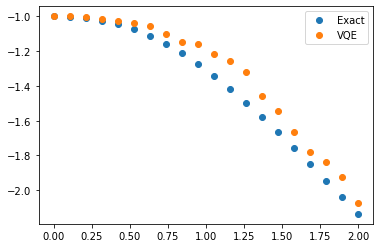

In [23]:
plt.plot(h_range, Exact_E_range_4, 'o', label = 'Exact')
plt.plot(h_range, vqe_E_range , 'o', label = 'VQE')

plt.legend()